In [15]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import random
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
# Load Train data 
df_train_prepared = pd.read_pickle('df_train_prepared')
train_payprice = df_train_prepared['payprice']
train_bidprice = df_train_prepared['bidprice']
train_click = df_train_prepared['click']

rtb_train = df_train_prepared.drop(['click','payprice','bidprice'], axis =1)
#drop(['userid','urlid','advertiser','hour','weekday', 'useragent','IP','region','city','adexchange','url','domain','slotid','slotvisibility','slotheight','slotwidth','slotprice','slotformat','creative','keypage','usertag'], axis = 1)
rtb_train.head()


,weekday,hour,region,city,adexchange,slotwidth,slotheight,slotprice,advertiser,useragent_encoded,IP_encoded,url_encoded,domain_encoded,slotid_encoded,slotvisibility_encoded,slotformat_encoded,creative_encoded,keypage_encoded,usertag_encoded
0,5,22,2,2,2,200,200,5,3427,31,253587,268016,21783,12845,2,0,104,0,744035
1,1,20,238,239,1,300,250,0,2821,29,282720,145905,728,50771,6,3,9,18,744035
2,3,13,40,41,2,250,250,5,3427,31,469429,262017,18426,9136,2,0,92,0,188248
3,6,23,1,1,1,160,600,0,1458,31,107833,658015,4770,50450,2,1,111,12,706361
4,5,6,216,233,2,728,90,133,2259,31,342191,157670,153,1517,8,3,84,18,744035


In [3]:
x  = df_train_prepared[df_train_prepared['click'] == 1]
len(x)/len(df_train_prepared)

0.0007375623256619447

In [4]:
# Scale validation data for better prediction when using logistic 
standard_scaler = StandardScaler().fit(rtb_train)
train_x = standard_scaler.transform(rtb_train)
train_x


In [5]:
# Load validation data
df_val_prepared = pd.read_pickle('df_val_prepared')

val_payprice = df_val_prepared['payprice']
val_bidprice = df_val_prepared['bidprice']
val_click = df_val_prepared['click']

rtb_validation = df_val_prepared.drop(['click','payprice','bidprice'], axis =1)
rtb_validation.head()

,weekday,hour,region,city,adexchange,slotwidth,slotheight,slotprice,advertiser,useragent_encoded,IP_encoded,url_encoded,domain_encoded,slotid_encoded,slotvisibility_encoded,slotformat_encoded,creative_encoded,keypage_encoded,usertag_encoded
0,4,20,79,79,1,160,600,0,1458,28,137474,45239,8595,14275,2,1,109,12,110919
1,1,21,79,79,1,950,90,0,3476,26,178167,109524,7201,14355,0,1,108,7,69995
2,4,8,2,2,2,300,250,5,3358,28,52834,75356,8455,7129,2,0,99,14,108448
3,5,15,201,205,2,336,280,5,3358,26,192739,27901,8931,8936,2,0,116,14,109043
4,1,18,134,135,2,200,200,5,3476,26,55070,135142,6582,423,1,0,42,5,6344


In [6]:
# Scale validation data for better prediction when using logistic 
standard_scaler = StandardScaler().fit(rtb_validation)
val_x = standard_scaler.transform(rtb_validation)
val_x

array([[ 0.54310061,  0.98980048, -0.68871428, ...,  1.01082565,
         0.28468824,  1.09400445],
       [-0.91767115,  1.14215317, -0.68871428, ...,  0.98465616,
        -0.52200851,  0.06389319],
       [ 0.54310061, -0.83843181, -1.44347493, ...,  0.74913079,
         0.60736694,  1.03180611],
       ...,
       [ 0.05617669,  0.22803703, -0.67891219, ..., -0.53317401,
        -1.32870527, -0.34415914],
       [ 1.51694846, -0.68607912, -0.67891219, ...,  1.01082565,
         0.28468824, -1.10209286],
       [ 1.51694846, -2.05725333,  0.65417155, ...,  0.85380873,
        -1.32870527, -0.56914043]])

In [7]:
test_data = pd.read_pickle('df_test_prepared')

standard_scaler = StandardScaler().fit(test_data)
test_x = standard_scaler.transform(test_data)

#np.save('test_data',test_x )

### Average CTR for Validation

In [8]:
# THIS IS AVERAGE CTR FOR VALIDATION DATA 

val_click_1 = df_val_prepared[df_val_prepared['click'] == 1]
val_AvgCTR =  float("{0:.5f}".format(len(val_click_1)/len(df_val_prepared['click'])))
val_AvgCTR 

0.00066

###  UNDER SAMPLING  

In [9]:
from imblearn.under_sampling import RandomUnderSampler

mean_class_size = int(pd.Series(train_click).value_counts().sum()/1500)
mean_class_size

ratio = {0: mean_class_size,
         1: mean_class_size}

rus = RandomUnderSampler (ratio = ratio, random_state = 0)
rus

train_x_rus, train_y_rus = rus.fit_sample(train_x, train_click)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_x, train_click, test_size = 0.8, random_state = 42)


In [85]:
log_clf = LogisticRegression()
log_clf.fit(train_x_rus, train_y_rus)

y_pred_log = log_clf.predict(val_x)
log_ctr = log_clf.predict_proba(val_x)[:,1]

conf_mx_log = confusion_matrix(val_click, y_pred_log)

print('CONFUSION MATRIX:')
print(conf_mx_log) 
print()
print('ACCURACY:')
print(accuracy_score(val_click, y_pred_log))
print()
print('ROC AUC RESULT:')
print(roc_auc_score(val_click, log_ctr))

CONFUSION MATRIX:
[[223919  79804]
 [    93    109]]

ACCURACY:
0.737116064818623

ROC AUC RESULT:
0.6846443556258905


In [64]:
# Predict pCTR for test data 
y_pred_log_test = log_clf.predict(test_x)
log_ctr_test = log_clf.predict_proba(test_x)[:,1]

logistic_clf = pd.DataFrame(columns=['pCTR'], data = log_ctr_test)
logistic_clf['click'] = y_pred_log_test
len(logistic_clf[logistic_clf['click'] == 1])


81189

### DECISION TREE CLASSIFIER 

In [16]:
# Train the model with train data (under sampling)
# Using Grid Search to find the parameters for the model

params = {'max_leaf_nodes': list(range(2, 200)), 'min_samples_split':[2, 3, 4]}
grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1, verbose = 1)
grid_search_tree.fit(train_x_rus, train_y_rus)

tree_best = grid_search_tree.best_estimator_

print('BEST PARAMETERS FOR RANDOM FOREST:')
print(tree_best)

Fitting 3 folds for each of 594 candidates, totalling 1782 fits


[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.7s


BEST PARAMETERS FOR RANDOM FOREST:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')


[Parallel(n_jobs=-1)]: Done 1782 out of 1782 | elapsed:   11.4s finished


In [84]:
# Use the trained model to predict ctr for validation data

y_pred_tree = grid_search_tree.predict(val_x)
tree_ctr = tree_best.predict_proba(val_x)[:,1]
conf_mx_tree = confusion_matrix(val_click, y_pred_tree)

print('CONFUSION MATRIX:')
print(conf_mx_tree) 
print()
print('ACCURACY:')
print(accuracy_score(val_click, y_pred_tree))

print()
print('ROC AUC RESULT:')
print(roc_auc_score(val_click, tree_ctr))


CONFUSION MATRIX:
[[245082  58641]
 [    80    122]]

ACCURACY:
0.8067911491321872

ROC AUC RESULT:
0.7494742799612584


In [18]:
# Predict pCTR for test data 
y_pred_tree_test = grid_search_tree.predict(test_x)
tree_ctr_test = tree_best.predict_proba(test_x)[:,1]

decision_tree = pd.DataFrame(columns=['pCTR'], data = tree_ctr_test)
decision_tree['click'] = y_pred_tree_test
len(decision_tree[decision_tree['click'] == 1])
#prediction.to_pickle('df_test_prediction')

57604

### RANDOM FOREST CLASSIFIER

#### This classifier takes around 10-20 mins to run, you can go eat dinner while waiting

In [19]:
# Train the model with train data (under sampling)
# Using Grid Search to find the parameters for the model

random_forest = Pipeline([ ('clf', RandomForestClassifier(criterion='gini'))])
parameters = {'clf__n_estimators':(300, 500, 1000),
               'clf__max_depth':(30, 50, 80), 
               'clf__min_samples_split':(2, 3), 
               'clf__min_samples_leaf':(1, 2)} 


grid_search_forest = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=5, verbose=1, scoring='accuracy') 
grid_search_forest.fit(train_x_rus, train_y_rus)

forest_best = grid_search_forest.best_estimator_
print('BEST PARAMETERS FOR RANDOM FOREST:')
print(forest_best)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.1min finished


BEST PARAMETERS FOR RANDOM FOREST:
Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


### This classifier will takes another 5 mins to run

In [81]:
# Use the trained model to predict ctr for validation data

y_pred_forest = grid_search_forest.predict(val_x)
forest_ctr = forest_best.predict_proba(val_x)[:,1]
conf_mx_forest = confusion_matrix(val_click, y_pred_forest)

print('CONFUSION MATRIX:')
print(confusion_matrix(val_click, y_pred_forest)) 
print()
print('ACCURACY:')
print( accuracy_score(val_click, y_pred_forest))
print()
print('ROC AUC RESULT:')
print(roc_auc_score(val_click, forest_ctr))

CONFUSION MATRIX:
[[228806  74917]
 [    66    136]]

ACCURACY:
0.7532845274327548

ROC AUC RESULT:
0.7847858244205907


In [21]:
# Predict pCTR for test data 
y_pred_forest_test = grid_search_forest.predict(test_x)
forest_ctr_test = forest_best.predict_proba(test_x)[:,1]

random_forest = pd.DataFrame(columns=['pCTR'], data = forest_ctr_test)
random_forest['click'] = y_pred_forest_test
len(random_forest[random_forest['click'] == 1])


75398

### Ada-Boost Ensemble 

- Boosting Tree Algorithm 
- Read about Ada-Boost 
- The algorithm starts with a simple decision tree for prediction
- For the wrong predicted data points 
- It will update the parameter for the wrong prediction 
- And use the model with the updated parameters to predict again
- This process is repeated many times until it is done 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier 
ada_clf = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth = 1), n_estimators = 1000, algorithm="SAMME.R", learning_rate= 0.008)
ada_clf.fit(train_x_rus, train_y_rus)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.008, n_estimators=1000, random_state=None)

In [80]:
# This takes a while to run too 
# Use Ada Boost to predict ctr for validation data

y_pred_ada = ada_clf.predict(val_x)
ada_ctr = ada_clf.predict_proba(val_x)[:,1]

print('CONFUSION MATRIX:')
print(confusion_matrix(val_click, y_pred_ada)) 
print()
print('ACCURACY:')
print( accuracy_score(val_click, y_pred_ada))
print()
print('ROC AUC RESULT:')
print(roc_auc_score(val_click, ada_ctr))


CONFUSION MATRIX:
[[258874  44849]
 [    94    108]]

ACCURACY:
0.8521247018178827

ROC AUC RESULT:
0.7510397778747263


In [24]:
# Predict pCTR for test data 
y_pred_ada_test = ada_clf.predict(test_x)
ada_ctr_test = ada_clf.predict_proba(test_x)[:,1]

ada_boost = pd.DataFrame(columns=['pCTR'], data = ada_ctr_test)
ada_boost['click'] = y_pred_ada_test
len(ada_boost[ada_boost['click'] == 1])
#prediction.to_pickle('df_test_prediction')

44618

### Combine the all classifiers

- This is Ensemble Classifier where all results are compared 
- And the voting classifier will choose the prediction that got most voted 

#### This will take a while to run 

In [88]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
rnd_clf = forest_best
tree_clf = tree_best
rnd_clf = forest_best
ada_clf = AdaBoostClassifier( 
    DecisionTreeClassifier(max_depth = 1), n_estimators = 1000, algorithm="SAMME.R", learning_rate= 0.008)


voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('tree',tree_clf ), ('ada', ada_clf)], voting = 'soft')
voting_clf.fit(train_x_rus, train_y_rus)


y_pred_voting = voting_clf.predict(val_x)
y_prob_voting = voting_clf.predict_proba(val_x)[:,1]

conf_max_voting = confusion_matrix(val_click, y_pred_voting)
print('CONFUSION MATRIX:')
print(conf_max_voting)
print()
print('ACCURACY:')
print( accuracy_score(val_click, y_pred_voting))
print()
print('ROC AUC RESULT:')
print(roc_auc_score(val_click, y_prob_voting))


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CONFUSION MATRIX:
[[242075  61648]
 [    78    124]]

ACCURACY:
0.7969038414082422

ROC AUC RESULT:
0.7780201168841214


In [89]:
# Voting classifier to predict pCTR for test data 

y_pred_voting_test = voting_clf.predict(test_x)
y_prob_voting_test = voting_clf.predict_proba(test_x)[:,1]

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [38]:
voting_clf = pd.DataFrame(columns=['pCTR'], data = y_prob_voting_test)
voting_clf['click'] = y_pred_voting_test
len(voting_clf[voting_clf['click'] == 1])

59469

### Recall Precision Trade off


In [92]:
dummyarray = np.empty((5, 3,))
df_models = pd.DataFrame(dummyarray)

df_models.columns = ["models", "accuracy_scores", "ROC_AUC_scores",]
df_models.loc[ 0 , 'models'] = "Logistic"
df_models.loc[ 1 , 'models'] = "Decision_Tree"
df_models.loc[ 2 , 'models'] = "Random_Forest"
df_models.loc[ 3 , 'models'] = "AdaBoost"
df_models.loc[ 4 , 'models'] = "Voting Classifier"

df_models.loc[ 0 , 'accuracy_scores'] = "0.74%"
df_models.loc[ 1 , 'accuracy_scores'] = "0.81%"
df_models.loc[ 2 , 'accuracy_scores'] = "0.75%"
df_models.loc[ 3 , 'accuracy_scores'] = "0.85%"
df_models.loc[ 4 , 'accuracy_scores'] = "0.80%"

df_models.loc[ 0 , 'ROC_AUC_scores'] = "0.68%"
df_models.loc[ 1 , 'ROC_AUC_scores'] = "0.75%"
df_models.loc[ 2 , 'ROC_AUC_scores'] = "0.79%"
df_models.loc[ 3 , 'ROC_AUC_scores'] = "0.75%"
df_models.loc[ 4 , 'ROC_AUC_scores'] = "0.78%"

In [93]:
df_models

,models,accuracy_scores,ROC_AUC_scores
0,Logistic,0.74%,0.68%
1,Decision_Tree,0.81%,0.75%
2,Random_Forest,0.75%,0.79%
3,AdaBoost,0.85%,0.75%
4,Voting Classifier,0.80%,0.78%


In [65]:
# I plotted for all models but i think only need 1 plot for the report


from sklearn.metrics import roc_curve

y_scores_log = log_ctr # score = proba of positive class
fpr_log, tpr_log, thresholds_log = roc_curve(val_click , y_scores_log)

y_scores_forest = forest_ctr # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(val_click , y_scores_forest)


y_scores_tree = tree_ctr # score = proba of positive class
fpr_tree, tpr_tree, thresholds_tree = roc_curve(val_click , y_scores_tree)

y_scores_ada = ada_ctr # score = proba of positive class
fpr_ada, tpr_ada, thresholds_ada = roc_curve(val_click , y_scores_ada)

y_scores_voting = y_prob_voting # score = proba of positive class
fpr_v, tpr_v, thresholds_v = roc_curve(val_click , y_scores_voting)


In [66]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label , color = 'red')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate or Recall ')


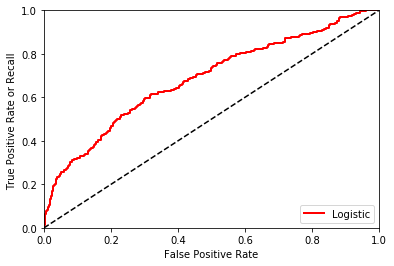

In [67]:
plot_roc_curve(fpr_log, tpr_log, "Logistic")
plt.legend(loc="lower right")
plt.show()

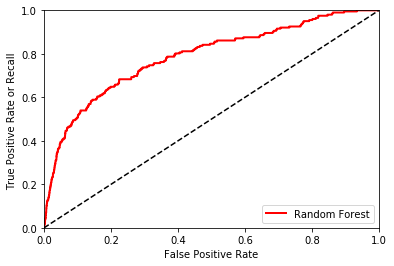

In [54]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

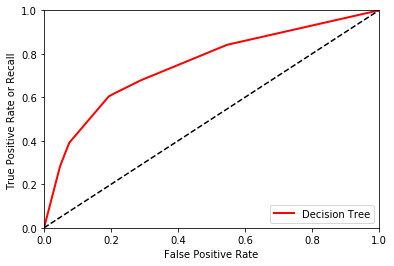

In [55]:
plot_roc_curve(fpr_tree, tpr_tree, "Decision Tree")
plt.legend(loc="lower right")
plt.show()

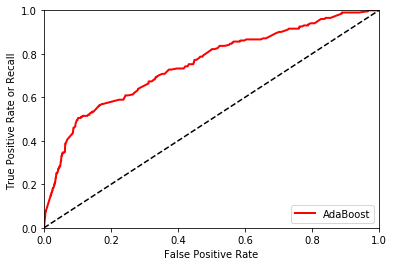

In [56]:
plot_roc_curve(fpr_ada, tpr_ada, "AdaBoost")
plt.legend(loc="lower right")
plt.show()

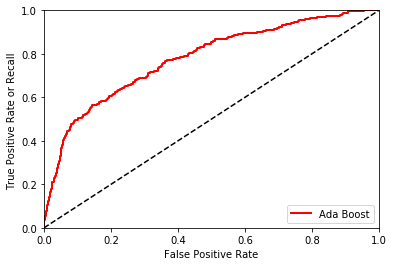

In [57]:
plot_roc_curve(fpr_v, tpr_v, "Ada Boost")
plt.legend(loc="lower right")
plt.show()

In [70]:
logistic_clf.head()
logistic_clf.to_pickle('logistic_pCTR')

In [71]:
ada_boost.head()
ada_boost.to_pickle('adaBoost_pCTR')

In [72]:
random_forest.head()
random_forest.to_pickle('random_forest_pCTR')

In [73]:
decision_tree.head()
decision_tree.to_pickle('decision_tree_pCTR')

In [74]:
voting_clf.head()
voting_clf.to_pickle('voting_clf_pCTR')

In [ ]:
# Voting classifier and AdaBoosting ,Random Forest are doing quite well 
# You can pick one and test with linear pricing or any pricing 
# I will test it tmr 

In [78]:
logistic_clf.head()

,pCTR,click
0,0.459939,0
1,0.899055,1
2,0.536450,1
3,0.457343,0
4,0.485565,0


In [77]:
random_forest.head()

,pCTR,click
0,0.517204,1
1,0.735407,1
2,0.491333,0
3,0.361643,0
4,0.349409,0


In [79]:
decision_tree.head()

,pCTR,click
0,0.330309,0
1,0.872951,1
2,0.357459,0
3,0.330309,0
4,0.330309,0


In [76]:
ada_boost.head()

,pCTR,click
0,0.483467,0
1,0.551060,1
2,0.502648,1
3,0.483505,0
4,0.486244,0
